In [2]:
from __future__ import print_function
import jax
import jax.numpy as np
import random
import numpy as onp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches

### Create mixture of gaussian data

In [167]:
def create_mixture_of_gaussian(batch_size, mean_var):
    nb_samples = batch_size #// len(mean_var) 
    data = [onp.random.multivariate_normal(params[0], params[1], int(nb_samples*params[2])) for params in mean_var]
    #label = [onp.zeros(data[0].shape[0]), onp.ones(data[1].shape[0])]
    return onp.vstack(data)#, onp.vstack(label).reshape(-1,)

def plot_dataset(ax, data, size=4, cmap="Reds", label="Ground truth"):
    ax.set_aspect('equal')
    ax.set_ylim((-size/2, size))
    ax.set_xlim((-size/2, size))
    ax.tick_params(labelsize=10)
    sns.kdeplot(
        data[:, 0],
        data[:, 1],
        cmap=cmap,
        ax=ax,
        )

In [168]:
batch_size=64
mean_std = [[[0,0],[[4,0],[0,2]], 0.9], [[5,5],[[0.5,0],[0,0.5]],0.1]]
data_indices = [create_mixture_of_gaussian(batch_size, mean_std) for _ in range(200)]
data = np.vstack([d for d in data_indices])
#label = np.vstack([d[1] for d in data_indices])


### MLE to estimate parameters of a Gaussian

Maximum Likelihood Estimation to estimate parameters of a gaussian distribution:
$$\mu_{ML} = \frac{1}{N} \sum_{n=1}^{N} x_{n}$$
$$\Sigma_{ML} = \frac{1}{N} \sum_{n=1}^{N} (x_{n} - \mu)(x_{n} - \mu)^T$$

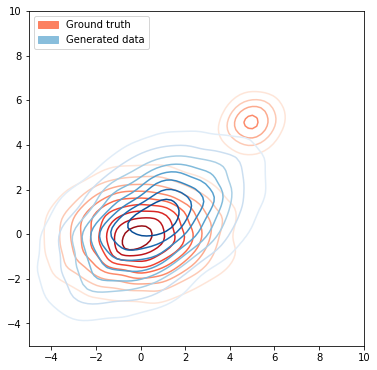

In [169]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data, size=10)

# Estimate the mean and covariance from data
mu_estimate = onp.mean(data, axis=0)
covar_estimate = onp.matmul(onp.transpose(data - mu_estimate),(data-mu_estimate)) / data.shape[0]
mean_var_estimate = [[mu_estimate, covar_estimate, 1.0]]

# Generate data from estimated mean and variance
gen_data_indices = [create_mixture_of_gaussian(batch_size, mean_var_estimate) for _ in range(100)]
generated_data = np.vstack([d for d in gen_data_indices])
plot_dataset(ax, generated_data, size=10, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")

### Lets create a simple model

In [196]:
from jax.experimental import stax
from jax import random
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Sigmoid, Flatten, LogSoftmax # neural network layers
from jax.experimental import optimizers
from jax import jit, grad

generator_net_init, generator_net_apply = stax.serial(
        Dense(40), Relu,
        Dense(40), Relu,
        Dense(40), Relu,
        Dense(2), 
)

discriminator_net_init, discriminator_net_apply = stax.serial(
        Dense(40), Relu,
        Dense(40), Relu,
        Dense(40), Relu,
        Dense(1), Sigmoid
)
latent_size = 10
key = random.PRNGKey(0)
key, subkey = random.split(key)
generator_in_shape = (-1, latent_size)
generator_out_shape, generator_net_params = generator_net_init(subkey, generator_in_shape)

key, subkey = random.split(key)
discriminator_in_shape = (-1, 2)
discriminator_out_shape, discriminator_net_params = discriminator_net_init(subkey, discriminator_in_shape)

In [197]:
# def BCE(output, y):
#     return np.mean(-y * np.log(output) - (1-y)*np.log(1-output), axis=0)[0]

def BCE(output, y):
    return np.mean(y * np.exp(output) - (1-y)*(1+output), axis=0)[0]

# def BCE(output, y):
#     return np.mean(-y * np.exp(-output) - (1-y)*(1+np.log(-output)), axis=0)[0]


def gen_loss(generator_params, discriminator_params, noise, y):
    gen_out = generator_net_apply(generator_params, noise)
    prediction = discriminator_net_apply(discriminator_params, gen_out)
    return BCE(prediction, y)
    
def disc_loss(p, x, y):
    prediction = discriminator_net_apply(p, x)
    loss_value = BCE(prediction, y)
    return loss_value
@jit
def generator_step(i, disc_opt_state, gen_opt_state, noise, y):
    generator_params = gen_get_params(gen_opt_state)
    discriminator_params = disc_get_params(disc_opt_state)
    g = grad(gen_loss)(generator_params, discriminator_params, noise, y)
    return gen_opt_update(i, g, gen_opt_state)

@jit
def discriminator_step(i, opt_state, x, y):
    p = disc_get_params(opt_state)
    g = grad(disc_loss)(p, x, y)
    return disc_opt_update(i, g, opt_state)

def sample_generator(gen_opt_state, input_data):
    gen_param = gen_get_params(gen_opt_state)
    return generator_net_apply(gen_param, input_data)

def train_discriminator(i, disc_opt_state, real_data, fake_data):
    disc_opt_state = discriminator_step(i, disc_opt_state, real_data, np.ones((real_data.shape[0],1), dtype=np.float32))    
    disc_opt_state = discriminator_step(i, disc_opt_state, fake_data, np.zeros((real_data.shape[0],1), dtype=np.float32))   
    return disc_opt_state
    
def train_generator(i, disc_opt_state, gen_opt_state, noise):    
    gen_opt_state = generator_step(i, disc_opt_state, gen_opt_state, noise, np.ones((fake_data.shape[0],1), dtype=np.float32))
    return gen_opt_state
    
    

In [198]:
# Initialize adam optimizer for generator and discriminator
gen_opt_init, gen_opt_update, gen_get_params = optimizers.adam(step_size=1e-3)
gen_opt_state = gen_opt_init(generator_net_params)

disc_opt_init, disc_opt_update, disc_get_params = optimizers.adam(step_size=1e-3)
disc_opt_state = disc_opt_init(discriminator_net_params)

In [199]:
for i in range(6000):
    real_data = data[onp.random.choice(data.shape[0], size=batch_size)]    
    noise = onp.random.normal(size=(batch_size, latent_size))
    fake_data = sample_generator(gen_opt_state, noise)
    # Train discriminator
    disc_opt_state = train_discriminator(i, disc_opt_state, real_data, fake_data)    
    # Train generator
    gen_opt_state = train_generator(i, disc_opt_state, gen_opt_state, noise)
    if i % 500 == 0:
        print(i)
    

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


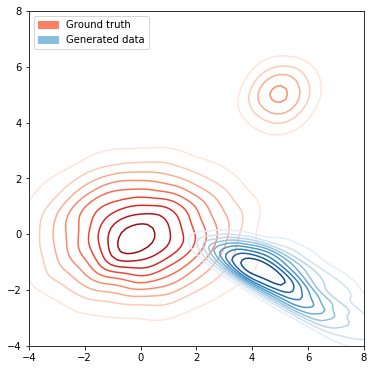

In [200]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data, size=10)

noise = onp.random.normal(size=(4000, latent_size))
# Generate data from GAN
#print(noise)
generated_data = sample_generator(gen_opt_state, noise)
#print(generated_data)
plot_dataset(ax, generated_data, size=8, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")

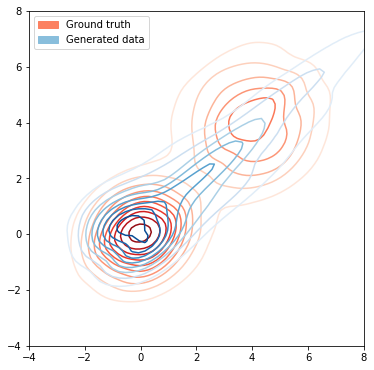

In [83]:
# Plot the ground truth data
fig, ax = plt.subplots(figsize=(6, 12))
plot_dataset(ax, data, size=10)

noise = onp.random.normal(size=(4000, 10))
# Generate data from GAN
#print(noise)
generated_data = sample_generator(gen_opt_state, noise)
#print(generated_data)
plot_dataset(ax, generated_data, size=8, cmap="Blues", label='Generated data')

# Add legends to the plot
groundtruth_patch = mpatches.Patch(color=sns.color_palette("Reds")[2], label="Ground truth")
gendata_patch = mpatches.Patch(color=sns.color_palette("Blues")[2], label="Generated data")
ax.legend(handles=[groundtruth_patch, gendata_patch], loc="upper left")

array([-0.44820198,  1.59990534, -1.48285392,  1.48787637])